In [49]:
from scripts import parse_timeloop_output
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import os

# Helper functions

In [50]:
# Returns total area & key/value array of area breakdown
def area_from_ART(filename):
    with open(filename, "r") as stream:
        try:
            kva = yaml.safe_load(stream)['ART']['tables']
            total_area = sum([kv['area'] for kv in  kva ])
            return total_area, kva
        except yaml.YAMLError as ex:
            print(ex)

In [51]:
# Loads from energy, area and performance metrics from timeloop-model dumps
def raw_metrics_from_example_dir(dirpth):
    mapstatsfn='timeloop-model.map+stats.xml'
    areafn='timeloop-model.ART.yaml'
    baseline_dir='output'
    saf_dir='output_w_SAF'
    baseline_res_={'example':dirpth}
    saf_res_={'example':dirpth}

    # Baseline raw metrics
    eyerisslike_bidir_bitmask_skipping_baseline = parse_timeloop_output.parse_timeloop_stats(os.path.join(dirpth,baseline_dir,mapstatsfn))
    baseline_res_['energy_pJ'] = float(eyerisslike_bidir_bitmask_skipping_baseline['energy_pJ'])
    baseline_res_['cycles'] = float(eyerisslike_bidir_bitmask_skipping_baseline['cycles'])
    baseline_res_['area'], baseline_res_['kva'] = area_from_ART(os.path.join(dirpth,baseline_dir,areafn))
    # Raw metrics with SAF
    eyerisslike_bidir_bitmask_skipping_saftool = parse_timeloop_output.parse_timeloop_stats(os.path.join(dirpth,saf_dir,mapstatsfn))
    saf_res_['energy_pJ'] = float(eyerisslike_bidir_bitmask_skipping_saftool['energy_pJ'])
    saf_res_['cycles'] = float(eyerisslike_bidir_bitmask_skipping_saftool['cycles'])
    saf_res_['area'], saf_res_['kva'] = area_from_ART(os.path.join(dirpth,saf_dir,areafn))

    return baseline_res_, saf_res_

In [52]:
# Lambdas for categorizing architectural components
is_ocm = lambda x: (not("MAC" in x['name'])) and (not("mac" in x['name'])) and (not ("BackingStorage" in x['name']))
is_arith = lambda x: ("MAC" in x['name']) or ("mac" in x['name'])

In [53]:
# Area breakdown from raw timeloop dump metrics
# NOTE: 
# - res_ dict is modified in-place
# - if baseline_res_ arg is provided then SAF uarch area will be computed
def area_breakdown_from_raw_metrics(res_, baseline_res_=None):
    res_['ocm_components'] = [kv['name'] for kv in res_['kva'] if is_ocm(kv)]
    res_['mac_components'] = [kv['name'] for kv in res_['kva'] if is_arith(kv)]

    scenario=''
    if baseline_res_ is None:
        # We are probably computing baseline area breakdown without SAF uarch overhead
        res_['ocm_area'] = sum([kv['area'] for kv in res_['kva'] if kv['name'] in res_['ocm_components']])        
        res_['mac_area'] = sum([kv['area'] for kv in res_['kva'] if kv['name'] in res_['mac_components']])
        scenario='Baseline' 
    else:
        # Assume we are computing area breakdown with SAF uarch overhead, which is computed relative to the baseline
        res_['ocm_area'] = baseline_res_['ocm_area']      
        res_['mac_area'] = baseline_res_['mac_area']
        augmented_ocm_area = sum([kv['area'] for kv in res_['kva'] if kv['name'] in res_['ocm_components']])
        augmented_mac_area = sum([kv['area'] for kv in res_['kva'] if kv['name'] in res_['mac_components']])
        res_['saf_uarch_area'] = (augmented_ocm_area - baseline_res_['ocm_area']) + (augmented_mac_area - baseline_res_['mac_area'])
        # Compute SAF uarch area percentage
        res_['saf_uarch_area_pct'] = 100.0*res_['saf_uarch_area']/res_['area']     
        scenario='SAFtools'

    # Percentage breakdowns applicable to any scenario
    res_['ocm_area_pct'] = 100.0*res_['ocm_area']/res_['area']
    res_['mac_area_pct'] = 100.0*res_['mac_area']/res_['area']

    # Summarize breakdown
    print(scenario + ' OCM area in um^2 (%): ', res_['ocm_area'],' (',int(res_['ocm_area_pct']),'%)', 'OCM components: ', res_['ocm_components'])
    print(scenario + ' Arithmetic in um^2 (%): ', res_['mac_area'],' (',int(res_['mac_area_pct']),'%)', 'Arithmetic components: ', res_['mac_components'])   
    if baseline_res_ is not None:
        print('SAFtools SAF uarch area in um^2 (%): ', res_['saf_uarch_area'],' (',int(res_['saf_uarch_area_pct']),'%)')       

In [54]:
def comparison_dataframes_from_breakdowns(saf_res_,baseline_res_):
    # Absolute area comparison dataframe
    data = {'Modeling': ['No SAFuarch modeling', 'w/ SAFuarch modeling'],
            'OCM area (um^2)': [baseline_res_['ocm_area'], saf_res_['ocm_area']],
            'SAFuarch area (um^2)': [0.0, saf_res_['saf_uarch_area']],
            'Arithmetic area (um^2)': [baseline_res_['mac_area'],saf_res_['mac_area']]}
    data['Total (um^2)'] = [(data['OCM area (um^2)'][0]+data['SAFuarch area (um^2)'][0]+data['Arithmetic area (um^2)'][0]),
                            (data['OCM area (um^2)'][1]+data['SAFuarch area (um^2)'][1]+data['Arithmetic area (um^2)'][1])]

    data_pct = {'Modeling': ['No SAFuarch modeling', 'w/ SAFuarch modeling'],
                'OCM area (%)':[int(baseline_res_['ocm_area_pct']), int(saf_res_['ocm_area_pct'])],
                'SAFuarch area (%)':[int(0.0), int(saf_res_['saf_uarch_area_pct'])],
                'Arithmetic area (%)':[int(baseline_res_['mac_area_pct']),int(saf_res_['mac_area_pct'])]}


    # Create DataFrame
    df = pd.DataFrame(data)
    #df.style.set_caption('Eyerissv2-like bidirectional bitmask skipping: PE area breakdown in um^2')
    df_pct = pd.DataFrame(data_pct)
    #df_pct.style.set_caption('Eyerissv2-like bidirectional bitmask skipping: PE area breakdown in %')
    
    # Print the output.
    display(df)
    display(df_pct)

    return df, data, df_pct, data_pct

In [55]:
def piechart_subplot(data_pct_,example_name_,idx,ax, subtitle_fontsize=18, pielblsz=14):
    categs = [categ for categ in data_pct_ if categ != 'Modeling']
    sizes = [data_pct_[categ][idx] for categ in categs]
    labels = [categ.split('(')[0] + ' \n' + str(data_pct_[categ][idx]) + '%' for categ in categs]
    print(data_pct_)
    ax.pie(sizes, labels=labels, textprops={'fontsize': pielblsz})
    if idx==0:
        ax.set_title('Baseline, no SAF uarch overhead', fontsize=subtitle_fontsize)
    else:
        ax.set_title('With SAF uarch overhead', fontsize=subtitle_fontsize)

def comparison_plot(data_,data_pct_,example_name_,plottype='piechart',suptitle_fontsize=22, subtitle_fontsize=18, sbplts_adj_top=1.2, sbpltlbl_fontsize=10):
    if plottype=='piechart':
    # Create two subplots and unpack the output array immediately
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 13))
        piechart_subplot(data_pct_,example_name_,0,ax1, pielblsz=sbpltlbl_fontsize)
        piechart_subplot(data_pct_,example_name_,1,ax2, pielblsz=sbpltlbl_fontsize)
        f.suptitle(example_name_ + ' area breakdown', fontsize=suptitle_fontsize)
        plt.subplots_adjust(top=sbplts_adj_top)
        #ax1.set_title('Sharing Y axis')
        #ax2.scatter(x, y)        

# Sparten-like bidirectional bitmask skipping

Baseline OCM area in um^2 (%):  5396.18  ( 81 %) OCM components:  ['eyeriss_v2_PE.PE.psum_spad', 'eyeriss_v2_PE.PE.iact_spad', 'eyeriss_v2_PE.PE.weight_spad', 'eyeriss_v2_PE.PE.reg']
Baseline Arithmetic in um^2 (%):  1248.8  ( 18 %) Arithmetic components:  ['eyeriss_v2_PE.PE.MAC']
SAFtools OCM area in um^2 (%):  5396.18  ( 4 %) OCM components:  ['eyeriss_v2_PE.PE.psum_spad', 'eyeriss_v2_PE.PE.iact_spad', 'eyeriss_v2_PE.PE.weight_spad', 'eyeriss_v2_PE.PE.reg']
SAFtools Arithmetic in um^2 (%):  1248.8  ( 1 %) Arithmetic components:  ['eyeriss_v2_PE.PE.MAC']
SAFtools SAF uarch area in um^2 (%):  105170.12899999999  ( 94 %)


,Modeling,OCM area (um^2),SAFuarch area (um^2),Arithmetic area (um^2),Total (um^2)
0,No SAFuarch modeling,5396.18,0.000,1248.8,6644.980
1,w/ SAFuarch modeling,5396.18,105170.129,1248.8,111815.109


,Modeling,OCM area (%),SAFuarch area (%),Arithmetic area (%)
0,No SAFuarch modeling,81,0,18
1,w/ SAFuarch modeling,4,94,1


{'Modeling': ['No SAFuarch modeling', 'w/ SAFuarch modeling'], 'OCM area (%)': [81, 4], 'SAFuarch area (%)': [0, 94], 'Arithmetic area (%)': [18, 1]}
{'Modeling': ['No SAFuarch modeling', 'w/ SAFuarch modeling'], 'OCM area (%)': [81, 4], 'SAFuarch area (%)': [0, 94], 'Arithmetic area (%)': [18, 1]}


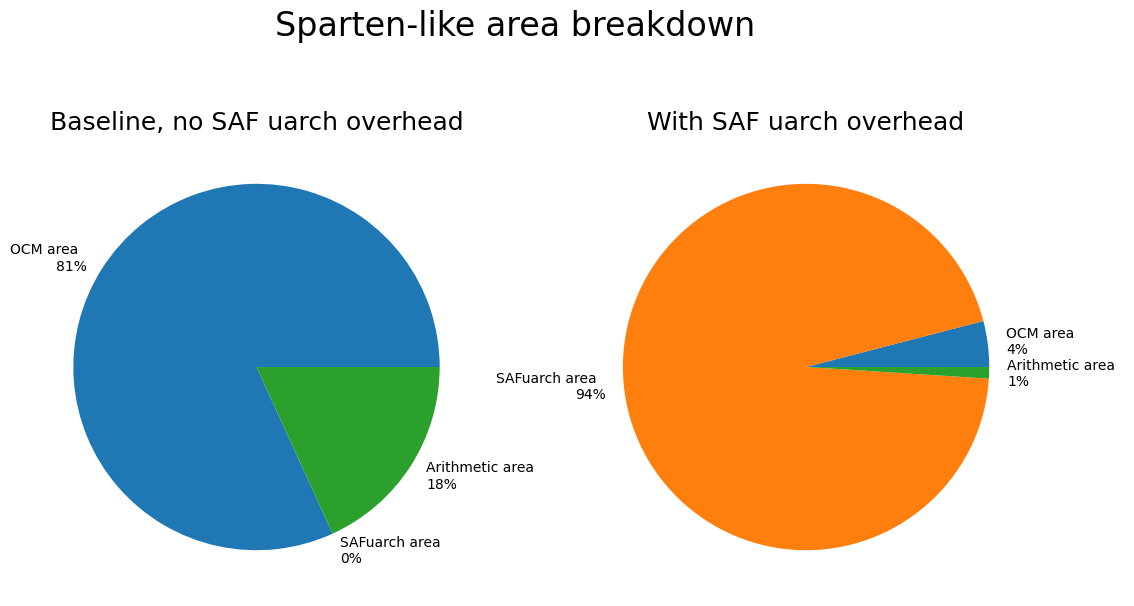

In [56]:
example_name='Sparten-like'
example_dir='sparten_like'
baseline_res, saf_res = raw_metrics_from_example_dir(example_dir)

# Breakdown
area_breakdown_from_raw_metrics(baseline_res)
area_breakdown_from_raw_metrics(saf_res,baseline_res_=baseline_res)
df, data, df_pct, data_pct = comparison_dataframes_from_breakdowns(saf_res,baseline_res)
comparison_plot(data,data_pct,example_name,plottype='piechart',suptitle_fontsize=24, subtitle_fontsize=18, sbplts_adj_top=1.3, sbpltlbl_fontsize=10)